In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [37]:
! wget http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Video_Games_5.json.gz

--2019-08-18 19:36:28--  http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Video_Games_5.json.gz
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 113104579 (108M) [application/x-gzip]
Saving to: ‘reviews_Video_Games_5.json.gz’

reviews_Video_Games 100%[===================>] 107.86M  3.78MB/s    in 35s     

2019-08-18 19:37:03 (3.12 MB/s) - ‘reviews_Video_Games_5.json.gz’ saved [113104579/113104579]



In [40]:
! gunzip reviews_Video_Games_5.json.gz

In [20]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml.feature import *
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.sql.functions import *

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
## import datetime as dt
## from datetime import datetime

In [43]:
! head -1 reviews_Video_Games_5*

{"reviewerID": "A2HD75EMZR8QLN", "asin": "0700099867", "reviewerName": "123", "helpful": [8, 12], "reviewText": "Installing the game was a struggle (because of games for windows live bugs).Some championship races and cars can only be \"unlocked\" by buying them as an addon to the game. I paid nearly 30 dollars when the game was new. I don't like the idea that I have to keep paying to keep playing.I noticed no improvement in the physics or graphics compared to Dirt 2.I tossed it in the garbage and vowed never to buy another codemasters game. I'm really tired of arcade style rally/racing games anyway.I'll continue to get my fix from Richard Burns Rally, and you should to. :)http://www.amazon.com/Richard-Burns-Rally-PC/dp/B000C97156/ref=sr_1_1?ie=UTF8&qid;=1341886844&sr;=8-1&keywords;=richard+burns+rallyThank you for reading my review! If you enjoyed it, be sure to rate it as helpful.", "overall": 1.0, "summary": "Pay to unlock content? I don't think so.", "unixReviewTime": 1341792000, "r

In [44]:
! wc -l reviews_Video_Games_5.json

231780 reviews_Video_Games_5.json


In [47]:
video_games = spark.read.format("json").option("inferSchema", "true").load("reviews_Video_Games_5.json")

In [53]:
video_games.cache()

DataFrame[asin: string, helpful: array<bigint>, overall: double, reviewText: string, reviewTime: string, reviewerID: string, reviewerName: string, summary: string, unixReviewTime: bigint]

In [54]:
video_games.printSchema()

root
 |-- asin: string (nullable = true)
 |-- helpful: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- overall: double (nullable = true)
 |-- reviewText: string (nullable = true)
 |-- reviewTime: string (nullable = true)
 |-- reviewerID: string (nullable = true)
 |-- reviewerName: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- unixReviewTime: long (nullable = true)



In [72]:
df1 = video_games.withColumn("review+summary", concat(col("summary"), lit(" "), col("reviewText")))

In [73]:
df1.limit(5).toPandas()

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime,review+summary
0,0700099867,"[8, 12]",1.0,Installing the game was a struggle (because of...,"07 9, 2012",A2HD75EMZR8QLN,123,Pay to unlock content? I don't think so.,1341792000,Pay to unlock content? I don't think so. Insta...
1,0700099867,"[0, 0]",4.0,If you like rally cars get this game you will ...,"06 30, 2013",A3UR8NLLY1ZHCX,"Alejandro Henao ""Electronic Junky""",Good rally game,1372550400,Good rally game If you like rally cars get thi...
2,0700099867,"[0, 0]",1.0,1st shipment received a book instead of the ga...,"06 28, 2014",A1INA0F5CWW3J4,"Amazon Shopper ""Mr.Repsol""",Wrong key,1403913600,Wrong key 1st shipment received a book instead...
3,0700099867,"[7, 10]",3.0,"I got this version instead of the PS3 version,...","09 14, 2011",A1DLMTOTHQ4AST,ampgreen,"awesome game, if it did not crash frequently !!",1315958400,"awesome game, if it did not crash frequently !..."
4,0700099867,"[2, 2]",4.0,I had Dirt 2 on Xbox 360 and it was an okay ga...,"06 14, 2011",A361M14PU2GUEG,"Angry Ryan ""Ryan A. Forrest""",DIRT 3,1308009600,DIRT 3 I had Dirt 2 on Xbox 360 and it was an ...


In [91]:
df1.describe().show()

+-------+-------------------+------------------+--------------------+----------+--------------------+-------------------+--------------------+--------------------+--------------------+
|summary|               asin|           overall|          reviewText|reviewTime|          reviewerID|       reviewerName|             summary|      unixReviewTime|      review+summary|
+-------+-------------------+------------------+--------------------+----------+--------------------+-------------------+--------------------+--------------------+--------------------+
|  count|             231780|            231780|              231780|    231780|              231780|             228967|              231780|              231780|              231780|
|   mean|7.198617864286957E9| 4.086396582966606|                null|      null|                null|7.177992341666667E7|            Infinity|1.2772167980533264E9|                null|
| stddev|3.628023820739709E9|1.2023296087789064|                null|      

In [ ]:
#reviewerID - ID of the reviewer, e.g. A2SUAM1J3GNN3B
#asin - ID of the product, e.g. 0000013714
#reviewerName - name of the reviewer
#helpful - helpfulness rating of the review, e.g. 2/3
#reviewText - text of the review
#overall - rating of the product
#summary - summary of the review
#unixReviewTime - time of the review (unix time)
#reviewTime - time of the review (raw)

In [92]:
df2 = df1.filter("overall !=3")

bucketizer = Bucketizer().setInputCol("overall").setOutputCol("label").setSplits((0.0, 4.0, 5.0))

df3 = bucketizer.transform(df2)

df3.groupBy("overall","label").count().show()

+-------+-----+------+
|overall|label| count|
+-------+-----+------+
|    2.0|  0.0| 13663|
|    5.0|  1.0|120185|
|    1.0|  0.0| 14853|
|    4.0|  1.0| 54804|
+-------+-----+------+



In [93]:
train, test = df3.randomSplit([0.7, 0.3])

In [94]:
print(train.count())
print(test.count())

142302
61203


In [95]:

### Takes all of the words in the review & summary text and converts them into an array of words for the next step
tokenizer = RegexTokenizer().setInputCol("review+summary").setOutputCol("reviewTokensUf").setPattern("\\s+|[,.()\"]")



# Remove useless words that provide no context or meaning - makes our analysis much cleaner
remover = StopWordsRemover().setStopWords(StopWordsRemover.loadDefaultStopWords("english")).setInputCol("reviewTokensUf").setOutputCol("reviewTokens")

In [96]:
cv = CountVectorizer().setInputCol("reviewTokens").setOutputCol("cv").setVocabSize(200000)

In [97]:
idf = IDF().setInputCol("cv").setOutputCol("features")

In [98]:
lr = LogisticRegression().setMaxIter(100).setRegParam(0.02).setElasticNetParam(0.3)

In [99]:
pl = Pipeline(stages = [tokenizer, remover, cv, idf, lr])

In [100]:
model = pl.fit(train)

In [118]:
vocabulary = model.stages[2].vocabulary



#

#word_weight = vocabulary.zip(weights)

#cdf = sc.parallelize(word_weight).toDF("word","weights")

In [106]:
len(vocabulary)

200000

In [107]:
lrModel = model.stages[-1]

In [137]:
weights = lrModel.coefficients.toArray()

In [141]:
vocabulary

['game',
 'like',
 'one',
 'games',
 'get',
 'play',
 'great',
 'good',
 'fun',
 'really',
 'time',
 'much',
 'also',
 'first',
 'even',
 'well',
 'new',
 'graphics',
 'story',
 'best',
 'playing',
 'still',
 '2',
 'better',
 '-',
 'played',
 'way',
 'many',
 'make',
 'go',
 'use',
 'lot',
 'little',
 'want',
 'love',
 '3',
 'buy',
 'characters',
 'people',
 'back',
 'system',
 'gameplay',
 'pretty',
 'different',
 'see',
 'think',
 'say',
 'find',
 'got',
 'around',
 'though',
 'character',
 'things',
 'level',
 'thing',
 'every',
 'series',
 'take',
 'know',
 'two',
 'never',
 'ever',
 'since',
 'mode',
 'feel',
 'xbox',
 'right',
 'player',
 'bad',
 'going',
 'need',
 'wii',
 'far',
 'world',
 'made',
 'hard',
 'another',
 'look',
 'hours',
 'easy',
 'bit',
 'times',
 'actually',
 'long',
 'makes',
 'worth',
 'however',
 'old',
 'controller',
 '4',
 'original',
 'something',
 'version',
 'online',
 'nice',
 'enough',
 'used',
 'ps3',
 'give',
 'may',
 '5',
 'levels',
 'enemies',
 'w

In [135]:
spark.createDataFrame(vocabulary, weights)

TypeError: schema should be StructType or list or None, but got: (200000,[2,6,7,8,12,14,15,16,18,19,21,31,32,34,36,43,50,68,79,80,94,104,106,107,108,109,114,119,125,128,131,144,145,148,152,157,158,171,175,182,184,191,193,196,199,206,208,209,223,249,267,269,284,294,295,299,304,310,314,326,346,349,360,374,375,383,389,407,408,419,443,456,462,469,476,478,485,501,508,512,514,515,542,547,554,565,573,576,579,593,594,603,609,630,634,637,653,657,658,666,670,689,712,733,734,762,765,773,782,790,799,803,823,842,848,863,866,932,935,944,948,957,960,989,1000,1005,1053,1076,1080,1083,1087,1098,1130,1144,1178,1179,1184,1186,1196,1199,1228,1229,1250,1255,1303,1325,1338,1341,1397,1402,1421,1427,1429,1450,1467,1469,1474,1478,1507,1508,1577,1583,1584,1694,1739,1756,1771,1788,1802,1821,1841,1868,1877,1898,1960,1963,2023,2075,2219,2236,2237,2258,2282,2318,2334,2423,2440,2458,2491,2500,2505,2616,2687,2703,2732,2743,2746,2754,2765,2984,3081,3435,3461,3571,3642,3685,3973,4006,4031,4083,4109,4186,4255,4277,4344,4620,4737,4797,4882,4900,4995,5153,5277,5279,5315,5371,5397,5418,5501,5626,5937,5956,5973,6203,6265,6479,6882,6887,6933,7026,7042,7359,7458,8156,8585,8921,9306,9665,9971,10446,11419,11492,11822,12875,13256,13534,14667,16238,16439,18093],[0.0032105565114726696,0.4261750504531438,0.09692209514589871,0.14458500393156912,0.060474116769296433,-0.018222095983718753,0.06568704977752952,0.010762570097616534,0.017444199812954267,0.26874846074635383,0.05747600227720293,0.04995907434243039,0.036292952838550066,0.18797811112343663,-0.022318576167628473,0.01869454115021424,0.03386466045343706,-0.09717391877029839,0.05967529980527558,0.08041225151226182,0.05601066128865062,0.04864556148281437,-0.05648570162195467,0.06548385629942777,0.009491732264944864,0.1743774236112885,0.008135227819807491,0.004785022388918653,0.021789287476307085,0.11632916257502518,0.003593113102076663,0.0053900081520292945,0.008855668430186318,-0.08812569562141918,0.07114717477926828,-0.12190247644437173,0.017438149483263464,0.0062880204943492,0.08626920433164553,-0.0007585631928145136,-0.02284899786169601,-0.009005185603889935,0.12862572952614276,0.1253664465264789,-0.007049169254048684,0.0011063636474966947,0.08655483404086314,-0.005812901300323731,0.015104611018900687,0.02413941656551447,0.11976616204251954,-0.044067342205387085,0.014913847831998967,0.02347319168180289,0.04712242772992674,-0.009293350482251012,0.02426695147663001,0.034425195076528144,-0.0049098745060825125,-0.019260631189716593,-0.2662059124042413,0.04714159141911644,0.015366465249348617,0.0031787885792829316,0.04356684065833182,0.020830647632925022,-0.09439348287853706,-0.0832295546373011,-0.03281392038211063,0.04256638329906925,-0.04431580674790166,-0.07727158438145453,0.007924751900196304,-0.05791242892817426,0.033945549929090706,0.010424315874362308,0.0036466299807295295,-0.0662738600266195,-0.0026637892364071276,0.014462151603482507,-0.11189393700181964,-0.006675613142575376,-0.06349431662726909,0.0025857117299243355,-0.02836184396312353,0.01795756484925677,0.013573411949049482,-0.011247069841996036,0.004079548755749395,-0.001175979501100325,0.013349880926480179,-0.014803492085692021,0.024697388337797707,-0.029975990021141118,0.012788757951370505,-0.012846722930739593,0.08576324964974955,-0.22924571187633386,-0.0646462850601229,0.017350413820279832,-0.2750948846081519,-0.00946414469946683,0.008368519395792898,0.07275888796524672,0.004275689714713867,-0.04129269183655785,0.038806922698916065,-0.08288673549248673,-0.22159109222998832,-0.1728911454532709,-0.03568216157076139,-0.14414247827128718,-0.007581387440146768,0.004879333662566278,-0.2950897676358491,-0.01241007592777911,-0.01700320180292998,0.0007365037759817382,-0.017499730171310277,-0.017240409305154313,-0.049614506858736036,0.06921445806084568,-0.05494837010700952,-0.0022533342296751375,-0.0008451994419781039,0.005238018624058857,-0.11503519347788155,-0.09087017134923302,-0.010967675761262173,0.012017314774003742,-0.03572769555101532,-0.024588012469696226,-0.055559740860066556,-0.15134135382291058,0.0019109352047294637,-0.026130102707788344,-0.1764641509645278,-0.05229498495721383,-0.06876126940150934,-0.028432013717852513,-0.00937723427190096,-0.028138983076486972,0.052178512629948305,-0.1046561825574606,0.0008991760286425963,-0.03567837688627194,-0.1485139201119047,-0.030650450198844735,-0.07021836565138723,-0.05380864419409413,-0.023574801501045954,-0.05458986665016482,-0.02165778683105268,0.016790056427924586,-0.022598116830730337,-0.10009320394075509,-0.022970089320369078,-0.06597532996276757,-0.20290258040207987,-0.05755898101827798,-0.03593919684392208,0.0026187128683191423,-0.027040701011587898,-0.007750266200819294,-0.07503857218461128,-0.01513956946952716,0.024117564316109126,-0.09784084563835561,-0.14983708285193728,-0.030762259910218,-0.03355634753523473,-0.0006481782126339736,-0.006519472499195744,-0.17865208441395186,-0.048828297668258934,-0.0390181036579806,-0.040093349231073876,-0.012736535029932015,-0.05965822026323776,-0.026377907227371156,-0.055306229501272036,-0.04589402301153265,-0.09579763589164877,-0.022044689520514627,-0.0925570212198826,-0.06978319327422457,-0.030471477451897475,-0.03064190724069046,-0.11748483632366653,-0.05387330687279818,-0.16319153944915135,-0.12333190672062486,-0.12813307827080073,-0.017949458599773684,-0.08094295524735738,-0.06352337748144747,-0.05144276318378003,-0.059010916558813506,-0.10510289755959962,-0.026245979474389433,-0.05708222602568096,-0.0046025276843900354,-0.04878893005687875,-0.041551947878379354,-0.09669953685863023,-0.012588907119241427,-0.03492189586874332,-0.10083951280268359,-0.006426754725008215,-0.006353352279260133,-0.016216028929602184,-0.15520056937298454,-0.03716019950294479,-0.06483969156218014,-0.09670530212351225,-0.03737549919544236,-0.02345503074903008,-0.044217940055493926,-0.03727178416167997,-0.06565048571863709,-0.012348821039695531,-0.010649097756965655,-0.04379896252222871,-0.007666261763669458,-0.012942372806107631,-0.10201153056031852,-0.01932936519950878,-0.04954784485253379,-0.038291204052328415,-0.0626765453270563,-0.013985917404411834,-0.0015624870020822807,-0.0097431456835364,-0.041666068163970275,-0.005418991208475404,-0.032593127418616544,-0.04111957648727385,-0.002388949138381544,-0.0075695587567976294,-0.019866694528008776,-0.03739894946324708,-0.12540493052289167,-0.021682405589605883,-0.00024223087470897343,-0.11467862939302201,-0.0181998163436394,-0.057594113897894116,-0.05243482856272501,-0.004096619660940617,-0.04894435345605848,-0.04252847077081834,-0.0014641848242670514,-0.0046005629216321715,-0.015113116354346798,-0.04224485345931014,-0.05563306832056843,-0.002470581965231157,-0.10405029183807142,-0.01957655313308867,-0.015048328412821362])

In [123]:
#vocabulary.toArray

AttributeError: 'list' object has no attribute 'toArray'

In [131]:
#word_weight = 

weights.zip(vocabulary)

AttributeError: 'function' object has no attribute 'zip'

In [116]:
lrModel.coefficients.toArray

<bound method SparseVector.toArray of SparseVector(200000, {2: 0.0032, 6: 0.4262, 7: 0.0969, 8: 0.1446, 12: 0.0605, 14: -0.0182, 15: 0.0657, 16: 0.0108, 18: 0.0174, 19: 0.2687, 21: 0.0575, 31: 0.05, 32: 0.0363, 34: 0.188, 36: -0.0223, 43: 0.0187, 50: 0.0339, 68: -0.0972, 79: 0.0597, 80: 0.0804, 94: 0.056, 104: 0.0486, 106: -0.0565, 107: 0.0655, 108: 0.0095, 109: 0.1744, 114: 0.0081, 119: 0.0048, 125: 0.0218, 128: 0.1163, 131: 0.0036, 144: 0.0054, 145: 0.0089, 148: -0.0881, 152: 0.0711, 157: -0.1219, 158: 0.0174, 171: 0.0063, 175: 0.0863, 182: -0.0008, 184: -0.0228, 191: -0.009, 193: 0.1286, 196: 0.1254, 199: -0.007, 206: 0.0011, 208: 0.0866, 209: -0.0058, 223: 0.0151, 249: 0.0241, 267: 0.1198, 269: -0.0441, 284: 0.0149, 294: 0.0235, 295: 0.0471, 299: -0.0093, 304: 0.0243, 310: 0.0344, 314: -0.0049, 326: -0.0193, 346: -0.2662, 349: 0.0471, 360: 0.0154, 374: 0.0032, 375: 0.0436, 383: 0.0208, 389: -0.0944, 407: -0.0832, 408: -0.0328, 419: 0.0426, 443: -0.0443, 456: -0.0773, 462: 0.0079, 4

In [ ]:
cdf.orderBy(desc("weights")).show(10)

In [ ]:
cdf.orderBy("weights").show(10)

In [ ]:
predictions = model.transform(testData)

In [ ]:
evaluator = BinaryClassificationEvaluator()  
areaUnderROC = evaluator.evaluate(predictions)

In [ ]:
amazon_vgdf

In [70]:
ten_votes = amazon_vgdf.select("*").filter(amazon_vgdf.total_votes > 10)

In [71]:
ten_votes_helpful = ten_votes.select("*", (ten_votes.helpful_votes / ten_votes.total_votes * 100).alias("helpfulness_perc"))
ten_votes_helpful.limit(5).toPandas()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,helpfulness_perc
0,US,36139671,R1BLS410YVZATX,B0019C4MU2,706806298,Dead Space,Video Games,4,5,12,N,N,Dead Space entertains and delivers.,[[ASIN:B0019C4MU2 Dead Space]]<br />Went and g...,2008-10-22,41.666667
1,US,27209921,R2L69G6AOSUUG9,B0006VHV8C,776039765,Nintendo DS Bundle with Spider-Man 2 and Pro G...,Video Games,5,12,13,N,N,Useful DS specs,There's a lot of pros and con opionions out th...,2005-01-26,92.307692
2,US,16118786,R1QP89M7O3PML2,B00178630A,111226018,Diablo III - PC/Mac,Video Games,1,15,18,N,N,not good,"I have played many games, I have played WoW fo...",2012-09-06,83.333333
3,US,48359535,R3SNU9UE4CSDCD,B00004U49F,229715170,The Mummy,Video Games,4,10,12,N,N,"Excellent fun, shoddy graphics","This game is very fun to play, with enemies a...",2000-12-29,83.333333
4,US,32631152,RWACLRD1DKL0C,B003O6CACS,305950563,Super Street Fighter IV Arcade Edition,Video Games,1,8,18,N,N,One VERY expensive game!,"Sure it was great when it came out, ok when it...",2011-08-12,44.444444


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f244bb62f60>]],
      dtype=object)

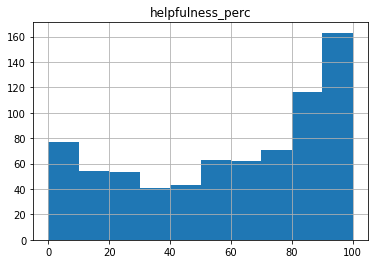

In [72]:
ten_votes_helpful.select("helpfulness_perc").toPandas().hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f244c1fbd30>]],
      dtype=object)

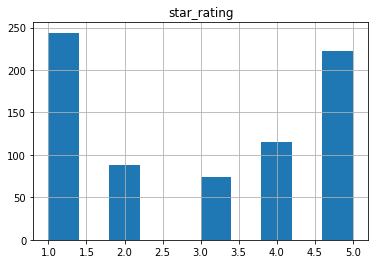

In [73]:
ten_votes_helpful.select("star_rating").toPandas().hist()

In [74]:
ten_votes_helpful.groupBy("verified_purchase").count().toPandas()

,verified_purchase,count
0,Y,174
1,N,569
